In [ ]:
#imports
import collections
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.metrics import roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from umap import UMAP
from scipy.stats import ttest_rel, t, skew, mode
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE
import shap
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


C:\Users\musta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import and merge data
clinical_df = pyreadr.read_r(r'C:\Users\musta\UCL MBBS\Year 3 Oncology\Cancer Reserach Project\Project Files\Main\LCCE_converted_data\20221109_TRACERx421_all_patient_df.rds')
clinical_df = pd.DataFrame(clinical_df[None])
display(clinical_df)

tumour_df = pyreadr.read_r(r'C:\Users\musta\UCL MBBS\Year 3 Oncology\Cancer Reserach Project\Project Files\Main\LCCE_converted_data\20221109_TRACERx421_all_tumour_df.rds')
tumour_df = pd.DataFrame(tumour_df[None])
display(tumour_df)


mutation_df = pyreadr.read_r(r'C:\Users\musta\UCL MBBS\Year 3 Oncology\Cancer Reserach Project\Project Files\MAIN\LCCE_converted_data\20221109_TRACERx421_mutation_table.rds')
mutation_df = pd.DataFrame(mutation_df[None])
display(mutation_df)

region_df = pyreadr.read_r(r'C:\Users\musta\UCL MBBS\Year 3 Oncology\Cancer Reserach Project\Project Files\MAIN\LCCE_converted_data\20221123_TRACERx421_mutation_table_region.rds')
region_df = pd.DataFrame(region_df[None])
display(region_df)

subclonal_df = pyreadr.read_r(r'C:\Users\musta\UCL MBBS\Year 3 Oncology\Cancer Reserach Project\Project Files\MAIN\LCCE_converted_data\20221109_TRACERx421_scna_table.rds')
subclonal_df = pd.DataFrame(subclonal_df[None])
display(subclonal_df)

transcriptomic_df = pyreadr.read_r(r'C:\Users\musta\UCL MBBS\Year 3 Oncology\Cancer Reserach Project\Project Files\MAIN\LCCE_converted_data\20221014_transcriptomic_DATA_2022-10-18_vst_counts.rds')
transcriptomic_df = pd.DataFrame(transcriptomic_df[None])
display(transcriptomic_df)

cloncal_df = pyreadr.read_r(r'C:\Users\musta\UCL MBBS\Year 3 Oncology\Cancer Reserach Project\Project Files\MAIN\LCCE_converted_data\20221110_TRACERx421_mutationSignature_weights\signature_weights_perTumour.rds')
cloncal_df = pd.DataFrame(cloncal_df[None])
display(cloncal_df)


combine_df = pd.merge(clinical_df, tumour_df, how = 'outer')
combine_df = pd.merge(combine_df, mutation_df, how= 'outer')
combine_df = pd.merge(combine_df, region_df, how= 'outer')

display(combine_df)
print(f"Number of columns:{combine_df.shape[1]}")
print(f"Number of rows:{combine_df.shape[0]}")

print("Column names in combine_df:")
for i, col in enumerate(combine_df.columns):
    print(f"{i}: {col}")


,patient_id,age,sex,ethnicity,cigs_perday,years_smoking,packyears,smoking_status_merged,is.family.lung,ECOG_PS,...,os_time,cens_dfs,dfs_time,cens_dfs_any_event,dfs_time_any_event,cens_lung_event,lung_event_time,Relapse_cat,Relapse_cat_new,tx100
0,CRUK0034,68,Female,White- Irish,20.0,35,35.000,Ex-Smoker,True,0.0,...,1849,0,1849,0,1849,0,1849,NaN,No rec,True
1,CRUK0150,81,Male,White- British,44.5,49,109.025,Ex-Smoker,False,0.0,...,1362,1,1362,1,1362,0,1362,NaN,No rec,False
2,CRUK0159,60,Male,White- British,20.0,38,38.000,Smoker,False,0.0,...,2224,1,2224,1,1935,0,2224,Second primary lung,No rec,False
3,CRUK0090,65,Male,White- British,10.0,35,17.500,Ex-Smoker,False,1.0,...,2365,1,1143,1,1143,1,1143,Intrathoracic,Intrathoracic,True
4,CRUK0045,85,Male,White- British,10.0,25,12.500,Ex-Smoker,False,1.0,...,986,1,917,1,917,1,917,Intrathoracic,Intrathoracic,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,CRUK0872,66,Male,White- British,20.0,54,54.000,Ex-Smoker,False,1.0,...,893,1,883,1,883,1,883,Intra & Extra,Intra & Extra,False
417,CRUK0817,64,Male,White- British,12.0,27,16.200,Ex-Smoker,False,1.0,...,453,1,203,1,203,1,203,Intrathoracic,Intrathoracic,False
418,CRUK0864,78,Female,White- British,10.0,30,15.000,Ex-Smoker,True,0.0,...,1434,0,1434,0,1434,0,1434,NaN,No rec,False
419,CRUK0810,59,Female,White- British,10.0,44,22.000,Smoker,False,1.0,...,493,1,197,1,197,1,197,Intra & Extra,Intra & Extra,False


,tumour_id,patient_id,clinical_sex,age,ethnicity,Histology_per_tumour_id_muttable,histology_3,LUAD_pred_subtype_with.IMA_per_tumour,site_per_lesion,pT_stage_per_lesion,pN_stage_per_lesion,size_pathology_per_lesion,vascular_invasion_per_lesion,pleural_invasion_per_lesion,smoking_status_merged,cigs_perday,years_smoking,pack_years,is.family.lung,pathologyTNM
0,CRUK0034,CRUK0034,Female,68,White- Irish,Invasive adenocarcinoma,LUAD,acinar,Right Upper Lobe,2a,0,40,Yes,No,Ex-Smoker,20.0,35,35.000,True,IB
1,CRUK0150,CRUK0150,Male,81,White- British,LCNEC,Other,NaN,Left Upper Lobe,3,0,75,Yes,No,Ex-Smoker,44.5,49,109.025,False,IIB
2,CRUK0159,CRUK0159,Male,60,White- British,Invasive adenocarcinoma,LUAD,acinar,Right Upper Lobe,2a,0,36,Yes,Yes,Smoker,20.0,38,38.000,False,IB
3,CRUK0090,CRUK0090,Male,65,White- British,Squamous cell carcinoma,LUSC,NaN,Right Upper Lobe,2a,1,35,Yes,Yes,Ex-Smoker,10.0,35,17.500,False,IIA
4,CRUK0045,CRUK0045,Male,85,White- British,Invasive adenocarcinoma,LUAD,papillary,Left Lower Lobe,2a,0,48,Yes,Yes,Ex-Smoker,10.0,25,12.500,False,IB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,CRUK0817,CRUK0817,Male,64,White- British,Invasive adenocarcinoma,LUAD,solid,Right Lower Lobe,3,0,130,No,Yes,Ex-Smoker,12.0,27,16.200,False,IIB
428,CRUK0864,CRUK0864,Female,78,White- British,Invasive adenocarcinoma,LUAD,solid,Right Lower Lobe,1b,1,27,No,No,Ex-Smoker,10.0,30,15.000,True,IIA
429,CRUK0810,CRUK0810,Female,59,White- British,Invasive adenocarcinoma,LUAD,acinar,Right Upper Lobe,2a,2,35,Yes,Yes,Smoker,10.0,44,22.000,False,IIIA
430,CRUK0881_Tumour1,CRUK0881,Male,84,White- British,Invasive adenocarcinoma,LUAD,acinar,Right Upper Lobe,NaN,0,NaN,Yes,NaN,Smoker,20.0,70,70.000,False,IIA


,patient_id,tumour_id,mutation_id,chr,start,stop,ref,var,Hugo_Symbol,func,...,AAChange,GL_VAF,GL_nAlt,GL_depth,ITHState,PyCloneClonal_SC,PyCloneCluster_SC,cleanCluster_SC,combTiming_SC,DriverMut
0,CRUK0005,CRUK0005,CRUK0005:19:34291428:G,chr19,34291428,34291428,G,T,KCTD15,intronic,...,NaN,0,0,187,1,S,3.0,True,subclonal,False
1,CRUK0005,CRUK0005,CRUK0005:19:9084770:C,chr19,9084770,9084770,C,A,MUC16,exonic,...,p.V2349L,0.39,2,510,1,C,2.0,True,early,False
2,CRUK0005,CRUK0005,CRUK0005:1:2160418:G,chr1,2160418,2160418,G,T,SKI,exonic,...,p.P71P,0,0,114,1,C,2.0,True,early,False
3,CRUK0005,CRUK0005,CRUK0005:19:40095981:G,chr19,40095981,40095981,G,T,LGALS13,exonic,...,p.G86C,0,0,659,1,C,2.0,True,early,False
4,CRUK0005,CRUK0005,CRUK0005:19:41313703:C,chr19,41313703,41313703,C,G,RAB4B-EGLN2,ncRNA_intronic,...,NaN,0,0,894,3,S,5.0,True,subclonal,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379003,CRUK0872,CRUK0872,CRUK0872:10:120513946:C,chr10,120513946,120513946,C,T,CACUL1,exonic,...,p.S110N,0,0,659,3,S,7.0,True,subclonal,False
379004,CRUK0872,CRUK0872,CRUK0872:14:99872776:T,chr14,99872776,99872776,T,C,SETD3,intronic,...,NaN,0,0,539,3,S,7.0,True,subclonal,False
379005,CRUK0872,CRUK0872,CRUK0872:8:110131566:C,chr8,110131566,110131566,C,A,TRHR,exonic,...,p.S360X,0,0,712,3,S,7.0,True,subclonal,False
379006,CRUK0872,CRUK0872,CRUK0872:1:51032853:G,chr1,51032853,51032853,G,C,FAF1,exonic,...,p.N388K,0,0,398,3,S,9.0,True,subclonal,False


,tumour_id,RegionID,is_lymphnode,mutation_id,var_count,depth,Is.present.region,CCF_pyclone_SC,CCF_phylo_SC,mut_cpn_SC,MajorCPN_SC,MinorCPN_SC,PyCloneCluster_SC,PyCloneClonal_SC,cleanCluster_SC
0,CRUK0005,CRUK0005:R1,False,CRUK0005:19:34291428:G,5.0,159.0,True,0.54,0.54,0.54,4,2,3.0,S,True
1,CRUK0005,CRUK0005:R1,False,CRUK0005:19:9084770:C,149.0,498.0,True,1.16,1.16,4.57,4,0,2.0,C,True
2,CRUK0005,CRUK0005:R1,False,CRUK0005:1:2160418:G,27.0,171.0,True,0.96,0.96,2.37,2,1,2.0,C,True
3,CRUK0005,CRUK0005:R1,False,CRUK0005:19:40095981:G,47.0,507.0,True,1.21,1.21,1.25,2,0,2.0,C,True
4,CRUK0005,CRUK0005:R1,False,CRUK0005:19:41313703:C,0.0,616.0,False,0.00,0.00,0.00,2,0,5.0,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403373,CRUK0872,CRUK0872:R4,False,CRUK0872:10:120513946:C,13.0,469.0,True,0.43,0.43,0.43,2,0,7.0,S,True
1403374,CRUK0872,CRUK0872:R4,False,CRUK0872:14:99872776:T,13.0,510.0,True,0.46,0.46,0.46,2,2,7.0,S,True
1403375,CRUK0872,CRUK0872:R4,False,CRUK0872:8:110131566:C,16.0,650.0,True,0.43,0.43,0.43,2,2,7.0,S,True
1403376,CRUK0872,CRUK0872:R4,False,CRUK0872:1:51032853:G,0.0,428.0,False,0.00,0.00,0.00,2,2,9.0,S,True


,patient_id,tumour_id,RegionID,chr,startpos,endpos,n.het,cnTotal,nMajor,nMinor,Ploidy,ACF,nAraw,nBraw,cpn_event_vs_ploidy,MSAI,samp_used_to_phase
0,CRUK0005,CRUK0005,CRUK0005:R1,1,762273,2252860,73,3,2,1,3.131282,0.15,2.463756,1.184761,neutral,False,CRUK0005_SU_T1-R2
1,CRUK0005,CRUK0005,CRUK0005:R1,1,2252970,2527412,26,2,2,0,3.131282,0.15,1.645818,0.284001,neutral,False,CRUK0005_SU_T1-R2
2,CRUK0005,CRUK0005,CRUK0005:R1,1,2527437,2700215,12,3,2,1,3.131282,0.15,2.187291,0.956066,neutral,False,CRUK0005_SU_T1-R3
3,CRUK0005,CRUK0005,CRUK0005:R1,1,2700332,28531815,600,3,2,1,3.131282,0.15,1.725844,0.708290,neutral,False,CRUK0005_SU_T1-R2
4,CRUK0005,CRUK0005,CRUK0005:R1,1,28534782,29649999,11,3,2,1,3.131282,0.15,1.711109,0.695610,neutral,False,CRUK0005_SU_T1-R2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419823,CRUK0555,CRUK0555_Tumour2,:R2,22,36962306,39176976,55,4,4,0,3.796640,0.19,4.207645,0.208286,neutral,False,CRUK0555_SU_T1-R1
419824,CRUK0555,CRUK0555_Tumour2,:R2,22,39262577,41604353,41,2,2,0,3.796640,0.19,2.385038,0.092194,loss,False,CRUK0555_SU_T1-R2
419825,CRUK0555,CRUK0555_Tumour2,:R2,22,41604399,41612295,6,2,2,0,3.796640,0.19,2.331273,0.000000,loss,False,CRUK0555_SU_T1-R1
419826,CRUK0555,CRUK0555_Tumour2,:R2,22,41648860,42899151,37,3,3,0,3.796640,0.19,3.403717,0.186030,neutral,False,CRUK0555_SU_T1-R1


,gene_id,CRUK0001:R1,CRUK0001:R3,CRUK0003:N1,CRUK0003:R1,CRUK0003:R2,CRUK0003:R3,CRUK0003:R4,CRUK0003:R6,CRUK0004:N1,...,CRUK0810:R8,CRUK0817:R1,CRUK0817:R2,CRUK0817:R3,CRUK0817:R4,CRUK0861:R1,CRUK0861:R2,CRUK0872:R2,CRUK0872:R3,CRUK0893:R2
0,A1BG,6.300184,6.162286,6.856617,5.958781,6.357624,6.821905,5.902041,6.401399,6.432464,...,7.834920,7.465417,8.034020,8.785558,7.053750,5.417938,5.156235,6.854803,7.461703,7.713047
1,A1BG-AS1,7.299841,6.776151,7.279843,5.725312,6.628837,6.500208,6.530271,6.766143,6.658945,...,7.129082,7.345260,6.228153,7.489663,6.868048,5.379690,4.908129,8.152088,7.981795,7.574490
2,A1CF,5.301922,4.889601,5.095236,5.995519,5.815590,5.182863,5.784206,5.318932,5.151936,...,5.460921,12.506811,11.830910,12.260495,12.199272,4.709863,5.157511,4.430448,4.937201,4.895586
3,A2M,15.720134,16.469908,16.638460,14.573329,13.801763,15.041881,15.030110,15.372627,17.019262,...,14.729034,16.455774,15.551857,16.364214,14.191571,11.119586,11.633414,12.830827,13.161700,14.686122
4,A2M-AS1,7.445299,7.508788,8.440294,7.400676,7.310232,7.244854,7.354586,7.915736,7.640877,...,8.192547,6.552023,7.264658,6.549136,6.698869,5.675605,5.442307,7.161121,6.606680,6.467002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20131,ZYG11A,6.934744,6.206086,5.549608,7.069685,7.142928,6.018108,6.974781,6.701684,5.143273,...,7.248301,8.646518,8.406275,8.602224,8.638037,4.430448,4.730079,7.752305,7.864738,7.427148
20132,ZYG11B,10.950248,11.353900,11.202813,10.637601,10.961294,10.370079,10.628441,10.221767,11.345517,...,10.863382,11.345725,10.797226,11.148708,11.205358,9.979869,10.072151,10.823689,10.815687,11.080243
20133,ZYX,11.223717,11.736417,11.920846,10.834188,10.655697,12.056378,11.243561,11.926702,12.087884,...,11.046629,8.869191,9.717659,9.971847,9.469835,10.157274,10.098016,11.254822,11.215824,10.796994
20134,ZZEF1,12.146845,11.880189,12.234642,10.949339,11.443063,11.425078,11.344482,11.453591,12.002540,...,12.142485,11.231180,11.775109,11.368125,11.303113,10.571726,10.949718,12.013014,11.650622,11.286182


,tumour_id,SBS1,SBS2,SBS4,SBS5,SBS13,SBS92,SBS44
0,CRUK0005,0.000000,0.000000,0.448935,0.320258,0.000000,0.149592,0.000000
1,CRUK0057,0.000000,0.000000,0.575864,0.308831,0.061541,0.000000,0.000000
2,CRUK0039,0.000000,0.114857,0.385550,0.331514,0.122732,0.000000,0.000000
3,CRUK0196,0.000000,0.000000,0.365268,0.331087,0.068352,0.196569,0.000000
4,CRUK0023,0.118615,0.000000,0.373573,0.451989,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
427,CRUK0666,0.000000,0.094516,0.323959,0.414580,0.166946,0.000000,0.000000
428,CRUK0678,0.089485,0.000000,0.420589,0.272629,0.000000,0.130111,0.000000
429,CRUK0787,0.000000,0.000000,0.271133,0.621406,0.000000,0.000000,0.000000
430,CRUK0872,0.000000,0.000000,0.199142,0.447115,0.000000,0.288593,0.000000


,patient_id,age,sex,ethnicity,cigs_perday,years_smoking,packyears,smoking_status_merged,is.family.lung,ECOG_PS,...,RegionID,is_lymphnode,var_count,depth,Is.present.region,CCF_pyclone_SC,CCF_phylo_SC,mut_cpn_SC,MajorCPN_SC,MinorCPN_SC
0,CRUK0001,84,Male,White- British,20.0,30,30.00,Ex-Smoker,False,1.0,...,CRUK0001:R1,False,50.0,895.0,True,0.64,0.64,0.64,3,1
1,CRUK0001,84,Male,White- British,20.0,30,30.00,Ex-Smoker,False,1.0,...,CRUK0001:R2,False,0.0,607.0,False,0.00,0.00,0.00,2,2
2,CRUK0001,84,Male,White- British,20.0,30,30.00,Ex-Smoker,False,1.0,...,CRUK0001:R3,False,1.0,920.0,False,0.00,0.00,0.02,2,1
3,CRUK0001,84,Male,White- British,20.0,30,30.00,Ex-Smoker,False,1.0,...,CRUK0001:R1,False,33.0,619.0,True,0.61,0.61,0.61,3,1
4,CRUK0001,84,Male,White- British,20.0,30,30.00,Ex-Smoker,False,1.0,...,CRUK0001:R2,False,0.0,434.0,False,0.00,0.00,0.00,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403373,CRUK0893,59,Female,White- British,15.0,43,32.25,Smoker,False,1.0,...,CRUK0893:R2,False,51.0,436.0,True,1.13,1.13,1.27,2,2
1403374,CRUK0893,59,Female,White- British,15.0,43,32.25,Smoker,False,1.0,...,CRUK0893:R1,False,10.0,249.0,True,0.64,0.64,0.64,1,1
1403375,CRUK0893,59,Female,White- British,15.0,43,32.25,Smoker,False,1.0,...,CRUK0893:R2,False,19.0,263.0,True,0.69,0.69,0.69,2,1
1403376,CRUK0893,59,Female,White- British,15.0,43,32.25,Smoker,False,1.0,...,CRUK0893:R1,False,10.0,207.0,True,0.80,0.80,0.80,1,1


Number of columns:87
Number of rows:1403378
Column names in combine_df:
0: patient_id
1: age
2: sex
3: ethnicity
4: cigs_perday
5: years_smoking
6: packyears
7: smoking_status_merged
8: is.family.lung
9: ECOG_PS
10: pathologyTNM
11: pT_stage_per_patient
12: pN_stage_per_patient
13: LVI_per_patient
14: size_pathology_per_patient
15: Surgery_type
16: histology_lesion1
17: lesion1_sampled
18: histology_lesion2
19: lesion2_sampled
20: histology_multi_full
21: histology_multi_full_genomically.confirmed
22: LUAD_pred_subtype
23: adjuvant_treatment_YN
24: adjuvant_treatment_given
25: num_cycle_na.added
26: CHMPlatDgName_cleaned
27: CHMOthDgName_cleaned
28: AdjRadStartTime_manual
29: AdjRadEndTime_manual
30: Recurrence_time_use
31: newPrim_time_use
32: first_dfs_any_event_rec.or.new.primary
33: first_event_during_followup
34: cens_os
35: os_time
36: cens_dfs
37: dfs_time
38: cens_dfs_any_event
39: dfs_time_any_event
40: cens_lung_event
41: lung_event_time
42: Relapse_cat
43: Relapse_cat_new
44

In [ ]:
#setting up the inclusion criteria and the dataframe to use inside the algorithm
without_df = combine_df[combine_df['PyCloneClonal_SC'] != 'S']
without_df = without_df[without_df['DriverMut'] == True]

numeric_columns = ['CCF_pyclone_SC', 'CCF_phylo_SC', 'mut_cpn_SC', 'GL_VAF']

for col in numeric_columns:
    without_df[col] = pd.to_numeric(without_df[col], errors='coerce')

mutation_features = without_df.groupby(['patient_id', 'Hugo_Symbol']).agg({
    'CCF_pyclone_SC': ['mean', 'std'],
    'CCF_phylo_SC': ['mean', 'std'],
    'mut_cpn_SC': ['mean', 'std'],
    'GL_VAF': ['mean', 'std', 'min', 'max']
}).reset_index()

pivot_table = mutation_features.pivot(index='patient_id', columns='Hugo_Symbol')
pivot_table.columns = ['_'.join(col).strip() for col in pivot_table.columns.values]
pivot_table.reset_index(inplace=True)
pivot_table.fillna(0, inplace=True)

def get_tp53_driver_clonality(group):
    if 'S' in group['PyCloneClonal_SC'].values:
        return 2
    elif 'C' in group['PyCloneClonal_SC'].values:
        return 1
    else:
        return 0

tp53_driver_mutations = combine_df[(combine_df['Hugo_Symbol'] == 'TP53') & (combine_df['DriverMut'] == True)]

clonalstatus_tp53 = tp53_driver_mutations.groupby('patient_id').apply(get_tp53_driver_clonality)
clonalstatus_tp53 = clonalstatus_tp53.reset_index()
clonalstatus_tp53.columns = ['patient_id', 'ClonalStatus_TP53']

final_df = pivot_table.merge(clonalstatus_tp53, on='patient_id', how='left')
final_df.fillna(0, inplace=True)

display(final_df)
print("class 1 patients:", (final_df['ClonalStatus_TP53'] == 1).sum())
print("class 2 patients:", (final_df['ClonalStatus_TP53'] == 2).sum())


C:\Users\musta\AppData\Local\Temp\ipykernel_12676\2108726998.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clonalstatus_tp53 = tp53_driver_mutations.groupby('patient_id').apply(get_tp53_driver_clonality)


,patient_id,CCF_pyclone_SC_mean_ACTN2,CCF_pyclone_SC_mean_ACVR1B,CCF_pyclone_SC_mean_ADCY2,CCF_pyclone_SC_mean_AKT1,CCF_pyclone_SC_mean_AMER1,CCF_pyclone_SC_mean_ANK2,CCF_pyclone_SC_mean_APC,CCF_pyclone_SC_mean_ARAF,CCF_pyclone_SC_mean_ARHGAP35,...,GL_VAF_max_WT1,GL_VAF_max_XPA,GL_VAF_max_XPC,GL_VAF_max_ZFP36L1,GL_VAF_max_ZFPM2,GL_VAF_max_ZMYM2,GL_VAF_max_ZNF180,GL_VAF_max_ZNF483,GL_VAF_max_ZRSR2,ClonalStatus_TP53
0,CRUK0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CRUK0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CRUK0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CRUK0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,CRUK0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,CRUK0861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
408,CRUK0864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409,CRUK0872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
410,CRUK0881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


class 1 patients: 229
class 2 patients: 25


In [4]:
#this was done to confirm that 1 patient out of the 26 had one subclonal TP53 mutation, but no clonal ones so was excluded from the analysis
tp53_subclonal_rows = combine_df[(combine_df['Hugo_Symbol'] == 'TP53') & (combine_df['PyCloneClonal_SC'] == 'S') & (combine_df['DriverMut'] == True)]
tp53_subclonal = tp53_subclonal_rows.drop_duplicates(subset='patient_id')

pd.set_option('display.max_rows', None) 
display(tp53_subclonal)

,patient_id,age,sex,ethnicity,cigs_perday,years_smoking,packyears,smoking_status_merged,is.family.lung,ECOG_PS,...,RegionID,is_lymphnode,var_count,depth,Is.present.region,CCF_pyclone_SC,CCF_phylo_SC,mut_cpn_SC,MajorCPN_SC,MinorCPN_SC
30059,CRUK0015,73,Female,White- British,0.0,0,0.00,Never Smoked,False,0.0,...,CRUK0015:R1,False,39.0,255.0,True,0.54,0.54,0.54,1,0
52259,CRUK0023,68,Male,White- British,42.5,26,55.25,Ex-Smoker,False,0.0,...,CRUK0023:R1,False,48.0,260.0,True,0.63,0.63,0.63,1,1
63866,CRUK0028,78,Female,White- British,10.0,35,17.50,Ex-Smoker,False,0.0,...,CRUK0028:R1,False,62.0,229.0,True,1.19,1.19,1.19,1,0
118396,CRUK0056,71,Female,White- British,40.0,45,90.00,Ex-Smoker,False,1.0,...,CRUK0056:R1,False,0.0,641.0,False,0.00,0.00,0.00,1,0
170932,CRUK0070,56,Male,White- British,20.0,42,42.00,Smoker,False,1.0,...,CRUK0070:R6,False,21.0,106.0,True,0.81,0.81,0.81,2,0
249335,CRUK0115,91,Male,White- British,15.0,63,47.25,Ex-Smoker,False,1.0,...,CRUK0115:R1,False,5.0,485.0,True,0.16,0.16,0.16,1,0
361152,CRUK0249,78,Female,White- British,10.0,59,29.50,Smoker,True,0.0,...,CRUK0249:R1,False,0.0,418.0,False,NaN,NaN,NaN,1,1
415361,CRUK0274,71,Female,White- British,10.0,57,28.50,Smoker,True,0.0,...,CRUK0274:R1,False,0.0,485.0,False,0.00,0.00,0.00,1,1
448353,CRUK0299,49,Female,White- British,20.0,34,34.00,Smoker,True,0.0,...,CRUK0299:R1,False,0.0,342.0,False,0.00,0.00,0.00,2,0
501326,CRUK0344,59,Male,White- Other,1.0,35,1.75,Smoker,False,0.0,...,CRUK0344:R2,False,96.0,404.0,True,0.79,0.79,0.79,1,0


All 2s in final_df: 30
TP53 only 2s: 25
TP53 only 1s: 229
ClonalStatus_TP53    25
dtype: int64


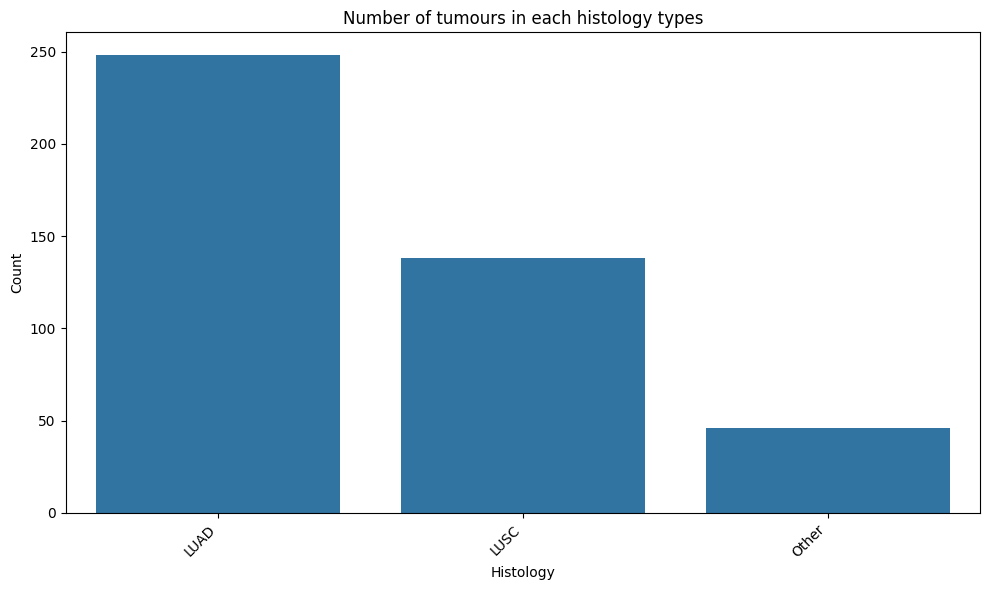

Number of tumours per histology type:
 histology_3
LUAD     248
LUSC     138
Other     46
Name: count, dtype: int64
Number of unique mutational IDs: 379008
Unique mutations with DriverMut being True: 2833


In [4]:
#drop tp53 columns and set up the final dataframe
print("All 2s in final_df:", (final_df == 2).sum().sum())
print("TP53 only 2s:", (final_df['ClonalStatus_TP53'] == 2).sum())
print("TP53 only 1s:", (final_df['ClonalStatus_TP53'] == 1).sum())

columns_to_drop = [col for col in final_df.columns if 'TP53' in col and col != 'ClonalStatus_TP53']
final_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

X = final_df.drop(columns=['patient_id', 'ClonalStatus_TP53'])
y = final_df['ClonalStatus_TP53']

clonal_columns = [c for c in final_df.columns if c.startswith('ClonalStatus_')]
print((final_df[clonal_columns] == 2).sum().sort_values(ascending=False))

X = final_df.drop(columns=['patient_id', 'ClonalStatus_TP53'])
y = final_df['ClonalStatus_TP53']

#graph to see distribution of histologies
plt.figure(figsize=(10, 6))
sns.countplot(data=tumour_df, x='histology_3')
plt.title('Number of tumours in each histology types')
plt.xlabel('Histology')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print("Number of tumours per histology type:\n", tumour_df['histology_3'].value_counts())
print("Number of unique mutational IDs:", combine_df['mutation_id'].nunique())

driver_mutations = combine_df[combine_df['DriverMut'] == True]
unique_driver_mutationa = driver_mutations['mutation_id'].nunique()
print("Unique mutations with DriverMut being True:", unique_driver_mutationa)


In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

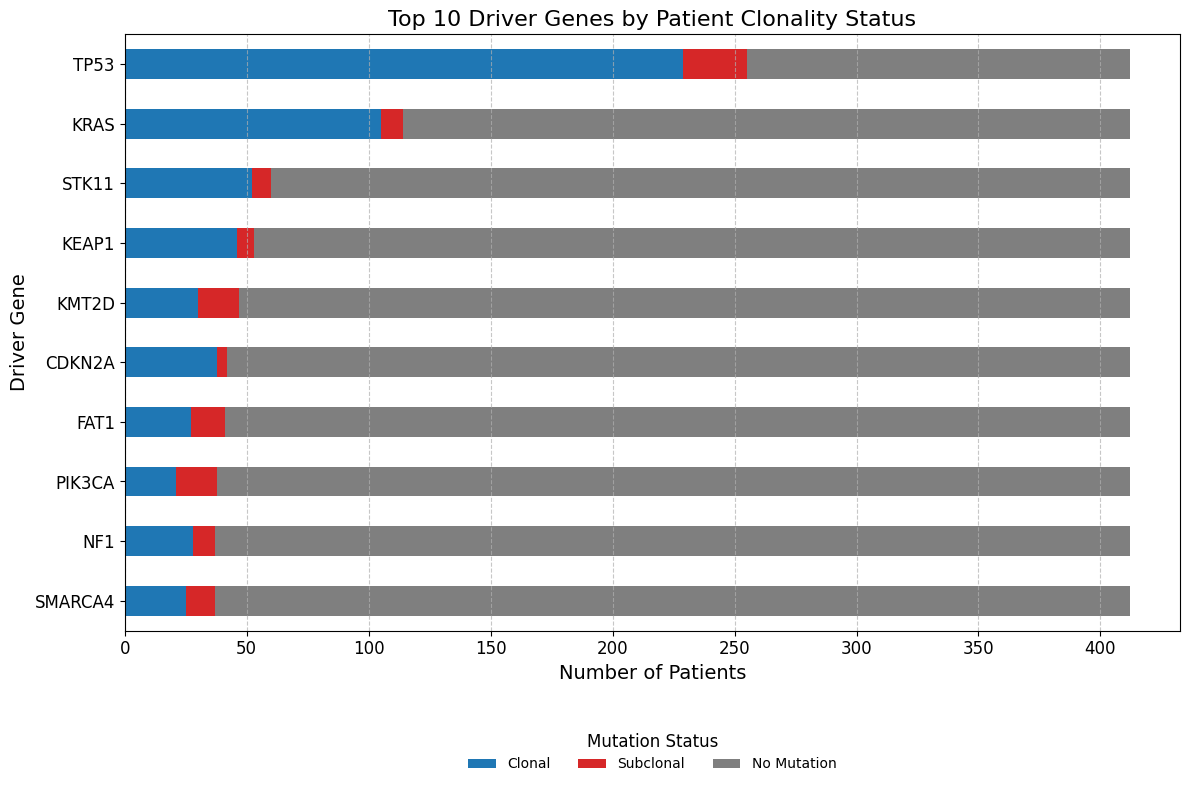

In [ ]:
#Analysis of driver mutations frequnecy in non-mutated, clonally mutated and subclonally mutated forms
driver_mutations = combine_df[combine_df['DriverMut'] == True]
total_patient_count = 412 

gene_counts = {}
gene_clonal_counts = {}

for gene in driver_mutations['Hugo_Symbol'].unique():
    gene_mutations = driver_mutations[driver_mutations['Hugo_Symbol'] == gene]
    
    patient_status = {}
    for _, mutation in gene_mutations.iterrows():
        patient_id = mutation['patient_id']
        clonal_status = mutation['PyCloneClonal_SC']
        
        if patient_id in patient_status:
            if clonal_status == 'S':
                patient_status[patient_id] = 'S'
        else:
            patient_status[patient_id] = clonal_status

    clonal_count = sum(1 for status in patient_status.values() if status == 'C')
    subclonal_count = sum(1 for status in patient_status.values() if status == 'S')
    total_with_mut = clonal_count + subclonal_count
    no_mut_count = total_patient_count - total_with_mut

    if total_with_mut > 0:
        gene_counts[gene] = total_with_mut
        gene_clonal_counts[gene] = {
            'Clonal': clonal_count,
            'Subclonal': subclonal_count,
            'No Mutation': no_mut_count
        }

sorted_genes = sorted(gene_counts.items(), key=lambda x: x[1], reverse=True)[:10]
genes = [x[0] for x in sorted_genes]

plot_data = []
for gene in genes:
    counts = gene_clonal_counts[gene]
    total = sum(counts.values())
    if total != total_patient_count:
        diff = total_patient_count - total
        counts['No Mutation'] += diff

    for status, count in counts.items():
        plot_data.append({
            'Gene': gene,
            'Status': status,
            'Count': count
        })

plot_df = pd.DataFrame(plot_data)

pivot_df = plot_df.pivot(index='Gene', columns='Status', values='Count').fillna(0)
pivot_df = pivot_df[['Clonal', 'Subclonal', 'No Mutation']]
pivot_df['TotalMut'] = pivot_df['Clonal'] + pivot_df['Subclonal']
pivot_df = pivot_df.sort_values('TotalMut', ascending=True).drop(columns='TotalMut')

colors = {'Clonal': '#1f77b4', 'Subclonal': '#d62728', 'No Mutation': '#7f7f7f'}

pivot_df.plot(
    kind='barh',
    stacked=True,
    color=[colors[col] for col in pivot_df.columns],
    figsize=(12, 8)
)

plt.title('Top 10 Driver Genes by Patient Clonality Status', fontsize=16)
plt.xlabel('Number of Patients', fontsize=14)
plt.ylabel('Driver Gene', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(
    title='Mutation Status',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False,
    fontsize=10,
    title_fontsize=12
)

plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


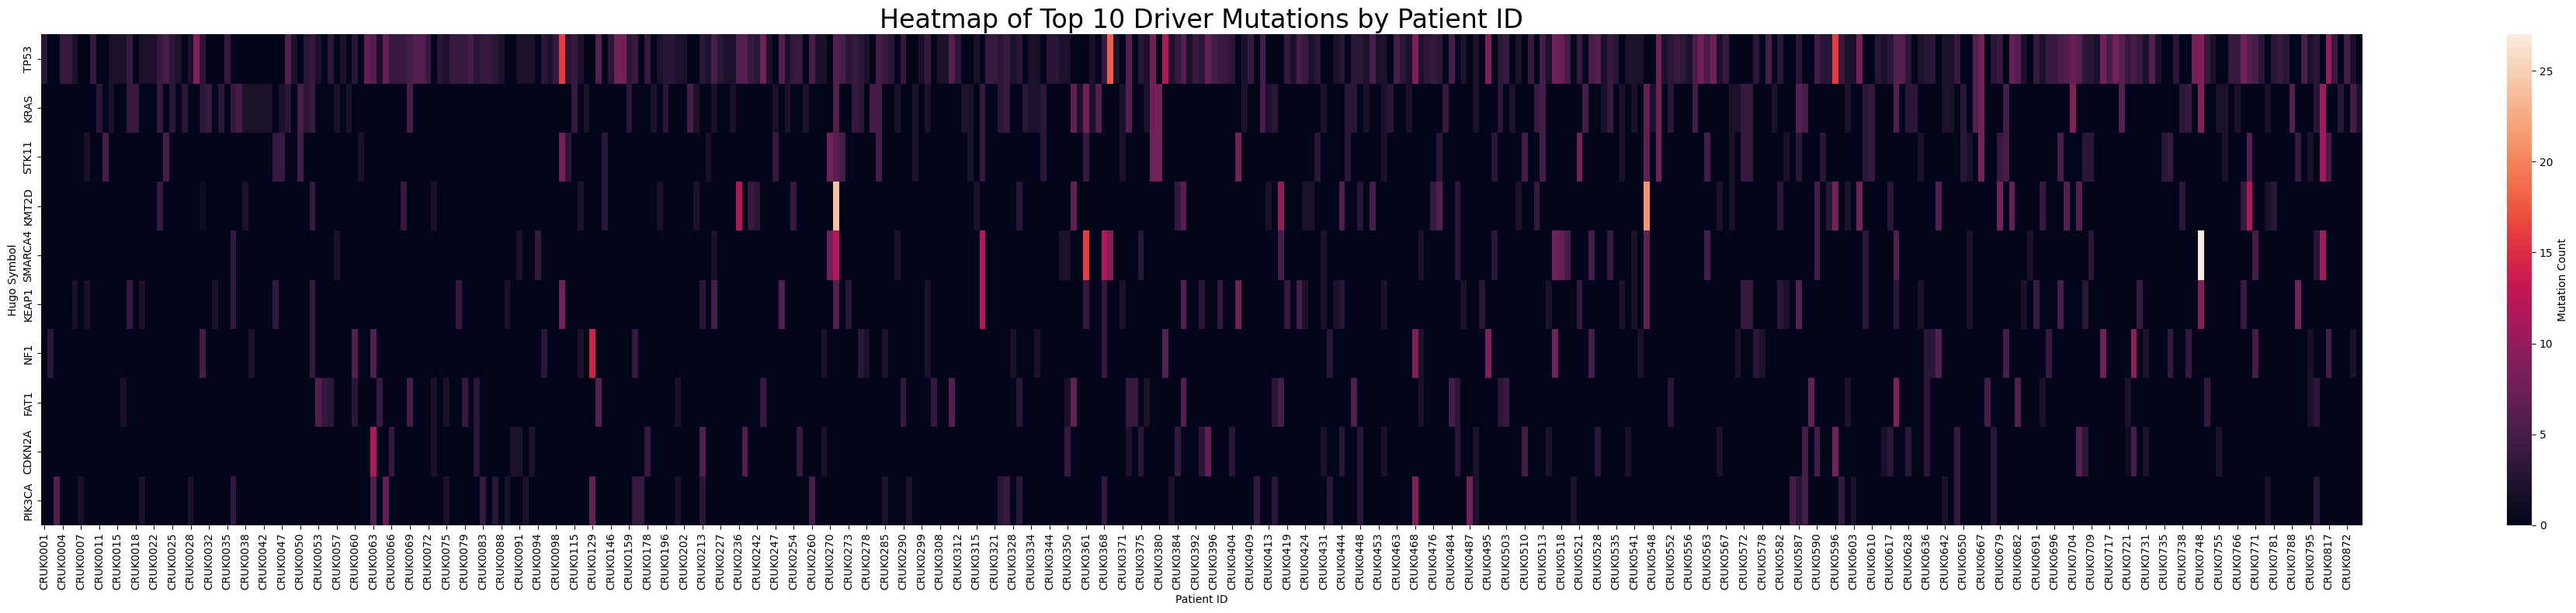

In [ ]:
#Heatmap of top 10 driver mutations by patient ID
driver_mut_df = combine_df[combine_df['DriverMut'] == True]

top_driver_mutations = driver_mut_df['Hugo_Symbol'].value_counts().head(10)

mutation_pivot = driver_mut_df.pivot_table(index='Hugo_Symbol', columns='patient_id', aggfunc='size', fill_value=0)
top_mutation_pivot = mutation_pivot.loc[top_driver_mutations.index]

patients_with_mutations = top_mutation_pivot.columns[top_mutation_pivot.sum(axis=0) > 0]
top_mutation_pivot = top_mutation_pivot[patients_with_mutations]

no_driver_mut_mask = top_mutation_pivot.sum(axis=0) == 0

plt.figure(figsize=(max(20, 0.1 * len(patients_with_mutations)), 8))
sns.heatmap(top_mutation_pivot, cmap='rocket', cbar_kws={'label': 'Mutation Count'})

xticklabels = plt.gca().get_xticklabels()
for idx, patient_id in enumerate(top_mutation_pivot.columns):
    if no_driver_mut_mask[patient_id] and idx < len(xticklabels):
        xticklabels[idx].set_color('red')

plt.title('Heatmap of Top 10 Driver Mutations by Patient ID', fontsize=24)
plt.xlabel('Patient ID')
plt.ylabel('Hugo Symbol')
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

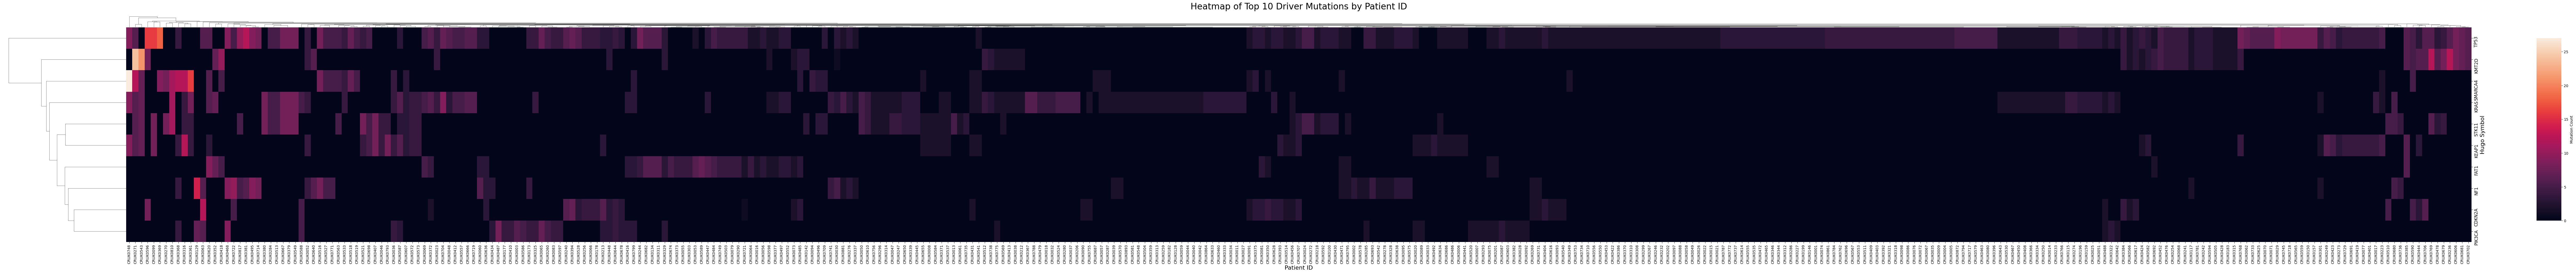

In [ ]:
#Clustered heatmap of top 10 driver mutations by patient ID
driver_mut_df = combine_df[combine_df['DriverMut'] == True]

top_driver_mutations = driver_mut_df['Hugo_Symbol'].value_counts().head(10)

mutation_pivot = driver_mut_df.pivot_table(index='Hugo_Symbol', columns='patient_id', aggfunc='size', fill_value=0)
top_mutation_pivot = mutation_pivot.loc[top_driver_mutations.index]

patients_with_mutations = top_mutation_pivot.columns[top_mutation_pivot.sum(axis=0) > 0]
top_mutation_pivot = top_mutation_pivot[patients_with_mutations]

no_driver_mut_mask = top_mutation_pivot.sum(axis=0) == 0

clustermap = sns.clustermap(
    top_mutation_pivot,
    cmap='rocket',
    figsize=(max(20, 0.25 * len(patients_with_mutations)), 10),
    cbar_kws={'label': 'Mutation Count'},
    cbar_pos=(1.02, 0.2, 0.01, 0.7),
    col_cluster=True,
    row_cluster=True,
    dendrogram_ratio=(0.05, 0.05)
)

xticklabels = clustermap.ax_heatmap.get_xticklabels()
for idx, patient_id in enumerate(top_mutation_pivot.columns):
    if idx < len(xticklabels):
        
        if no_driver_mut_mask[patient_id]:
            xticklabels[idx].set_color('red')
        else:
            xticklabels[idx].set_color('black')


clustermap.ax_heatmap.set_title('Heatmap of Top 10 Driver Mutations by Patient ID', fontsize=24, pad=50)
clustermap.ax_heatmap.set_xlabel('Patient ID', fontsize=16)
clustermap.ax_heatmap.set_ylabel('Hugo Symbol', fontsize=16)

yticklabels = clustermap.ax_heatmap.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(12)

plt.show()

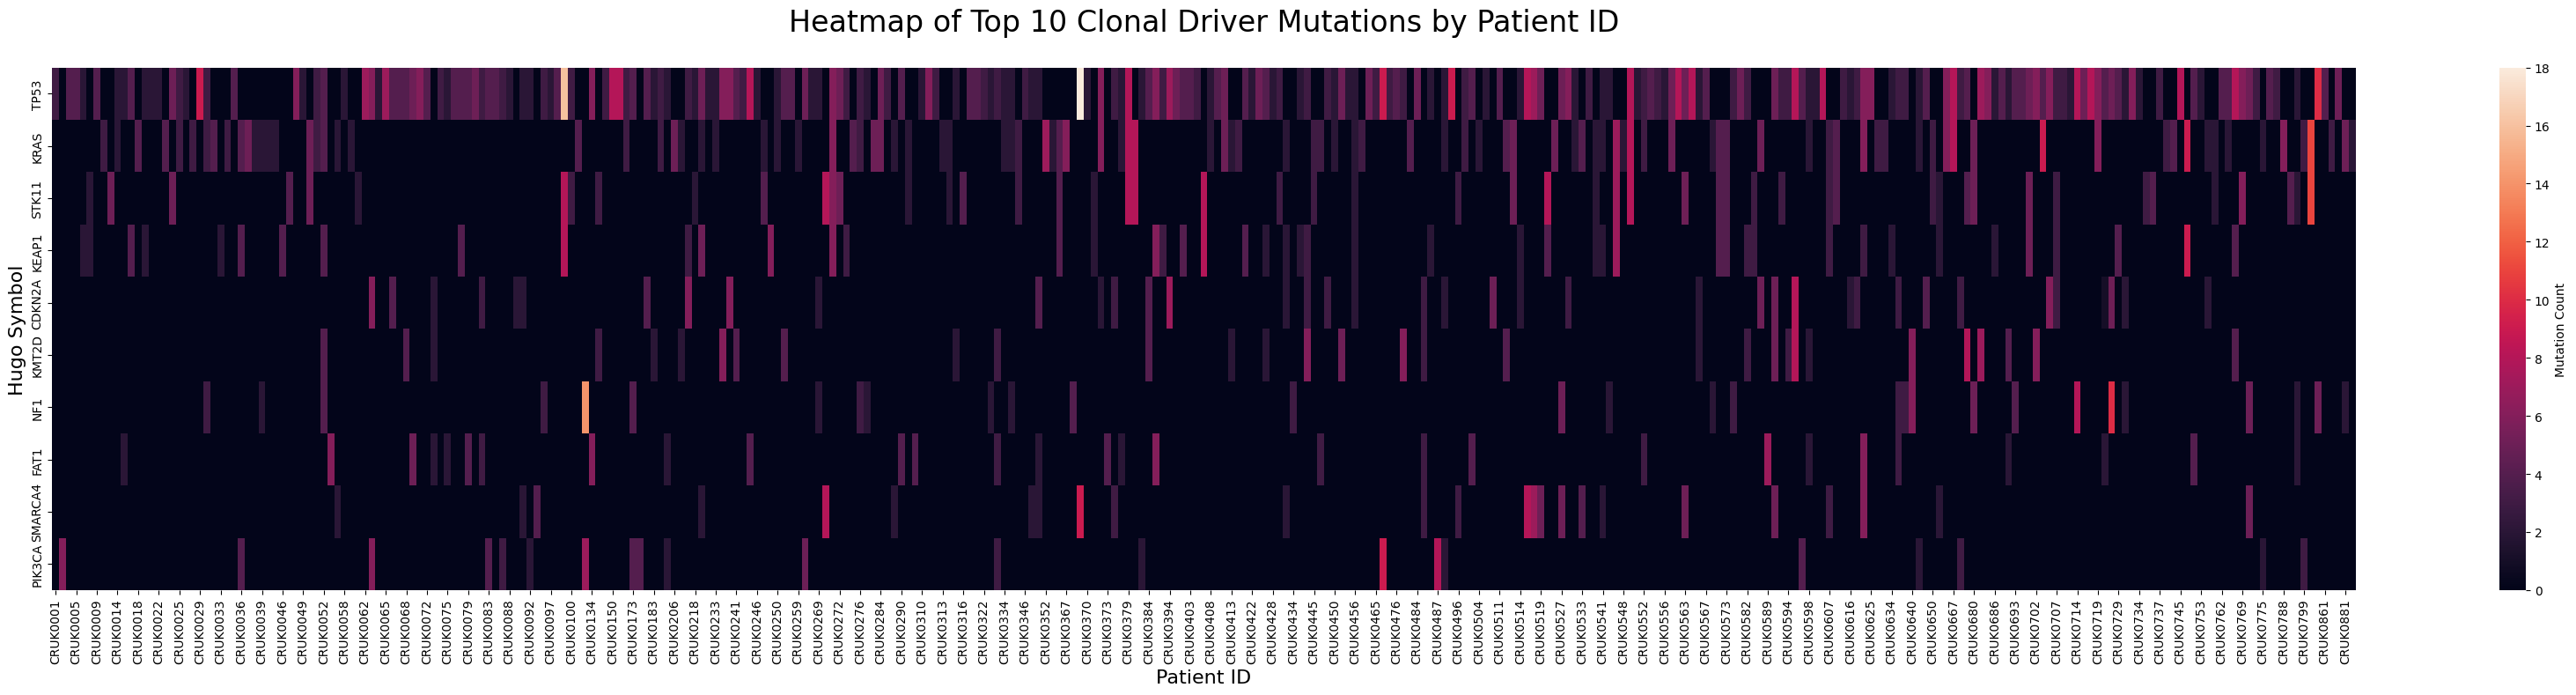

In [ ]:
#Heatmap for top 10 clonal driver mutations by patient ID

driver_mut_df = combine_df[combine_df['DriverMut'] == True]
early_driver_mut_df = driver_mut_df[driver_mut_df['PyCloneClonal_SC'] == 'C']
top_early_driver_mutations = early_driver_mut_df['Hugo_Symbol'].value_counts().head(10)

early_mutation_pivot = early_driver_mut_df.pivot_table(index='Hugo_Symbol', columns='patient_id', aggfunc='size', fill_value=0)
top_early_mutation_pivot = early_mutation_pivot.loc[top_early_driver_mutations.index]

all_patient_ids = [f'CRUK{str(i).zfill(4)}' for i in range(1, int(max(combine_df['patient_id'].str[4:])) + 1)]

top_early_mutation_pivot = top_early_mutation_pivot.reindex(columns=all_patient_ids, fill_value=0)

patients_with_early_mutations = top_early_mutation_pivot.columns[top_early_mutation_pivot.sum(axis=0) > 0]
top_early_mutation_pivot = top_early_mutation_pivot[patients_with_early_mutations]
no_early_driver_mut_mask = top_early_mutation_pivot.sum(axis=0) == 0

plt.figure(figsize=(max(20, 0.1 * len(patients_with_early_mutations)), 8))
sns.heatmap(top_early_mutation_pivot, cmap='rocket', cbar_kws={'label': 'Mutation Count'})

xticklabels = plt.gca().get_xticklabels()
for label in xticklabels:
    label.set_fontsize(10)
    text = label.get_text()
    if text in no_early_driver_mut_mask.index and no_early_driver_mut_mask[text]:
        label.set_color('red')
    else:
        label.set_color('black')
    

plt.title('Heatmap of Top 10 Clonal Driver Mutations by Patient ID', fontsize=24, pad=30)
plt.xlabel('Patient ID', fontsize=16)
plt.ylabel('Hugo Symbol', fontsize=16)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

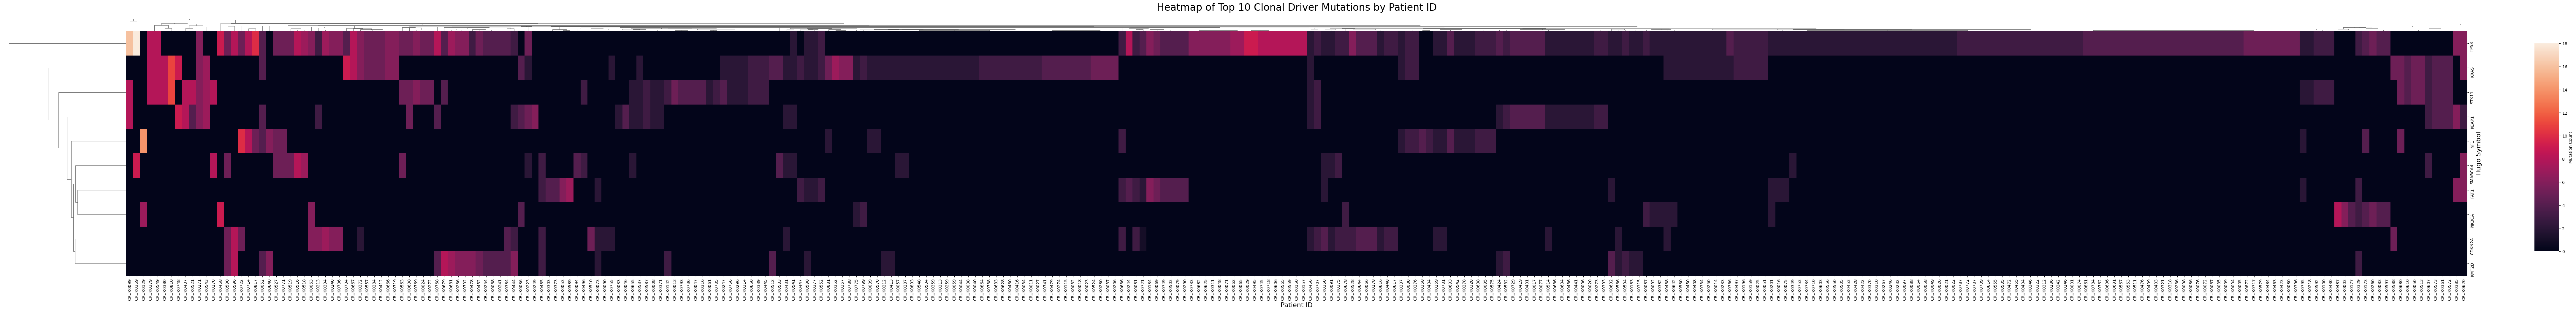

In [ ]:
#clustered heatmap for top 10 clonal driver mutations by patient ID
driver_mut_df = combine_df[combine_df['DriverMut'] == True]
early_driver_mut_df = driver_mut_df[driver_mut_df['PyCloneClonal_SC'] == 'C']

top_clonal_driver_mutations = early_driver_mut_df['Hugo_Symbol'].value_counts().head(10)

early_mutation_pivot = early_driver_mut_df.pivot_table(index='Hugo_Symbol', columns='patient_id', aggfunc='size', fill_value=0)
top_early_mutation_pivot = early_mutation_pivot.loc[top_clonal_driver_mutations.index]

all_patient_ids = [f'CRUK{str(i).zfill(4)}' for i in range(1, int(max(combine_df['patient_id'].str[4:])) + 1)]

top_early_mutation_pivot = top_early_mutation_pivot.reindex(columns=all_patient_ids, fill_value=0)

patients_with_early_mutations = top_early_mutation_pivot.columns[top_early_mutation_pivot.sum(axis=0) > 0]
top_early_mutation_pivot = top_early_mutation_pivot[patients_with_early_mutations]

no_early_driver_mut_mask = top_early_mutation_pivot.sum(axis=0) == 0

clustermap = sns.clustermap(
    top_early_mutation_pivot,
    cmap='rocket',
    figsize=(max(20, 0.25 * len(patients_with_early_mutations)), 10),
    cbar_pos=(1.02, 0.2, 0.01, 0.7),
    col_cluster=True,
    row_cluster=True,
    cbar_kws={'label': 'Mutation Count'},
    dendrogram_ratio=(0.05, 0.05)
)

xticklabels = clustermap.ax_heatmap.get_xticklabels()
for label in xticklabels:
    label.set_fontsize(10)
    text = label.get_text()
    if text in no_early_driver_mut_mask.index and no_early_driver_mut_mask[text]:
        label.set_color('red')
    else:
        label.set_color('black')

yticklabels = clustermap.ax_heatmap.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(10)

clustermap.ax_heatmap.set_title('Heatmap of Top 10 Clonal Driver Mutations by Patient ID', fontsize=24, pad=50)
clustermap.ax_heatmap.set_xlabel('Patient ID', fontsize=16)
clustermap.ax_heatmap.set_ylabel('Hugo Symbol', fontsize=16)
plt.show()

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#preliminary compariosn of models and then 5x5 cross-validation
y = pd.Series(y)
y_binary = y.copy()
y_binary[y_binary.isin([1, 2])] = 1
y_binary[y_binary == 0] = 0

mask = y_binary.isin([0, 1])
X_filtered = X[mask].select_dtypes(include=[np.number])
y_filtered = y_binary[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.15, random_state=42, stratify=y_filtered
)

pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_pca, y_train)
y_proba_rf = rf.predict_proba(X_test_pca)[:, 1]

mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    alpha=1e-4,
    max_iter=300,
    random_state=42
)
mlp.fit(X_train_pca, y_train)
y_proba_mlp = mlp.predict_proba(X_test_pca)[:, 1]

lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
lr.fit(X_train_pca, y_train)
y_proba_lr = lr.predict_proba(X_test_pca)[:, 1]

def optimise_threshold(y_true, y_proba, label=1):
    thresholds = np.linspace(0.1, 0.9, 100)
    best_f1 = 0
    best_threshold = 0.5
    best_pred = None

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=label)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
            best_pred = y_pred

    return best_threshold, best_f1, best_pred

def evaluate_model(name, y_true, y_proba):
    best_thresh, best_f1, y_pred = optimise_threshold(y_true, y_proba, label=1)
    if y_pred is None:
        print(f"\n{name}: No threshold achieved recall ≥ 0.9")
        return
    print(f"\n{name}")
    print(f"Optimal Threshold (Recall ≥ 0.9): {best_thresh:.2f}")
    print(f"Best F1 with Recall ≥ 0.9: {best_f1:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Precision / Recall / F1 (Class 1 - Mutated):")
    print("Precision:", precision_score(y_true, y_pred, pos_label=1))
    print("Recall:   ", recall_score(y_true, y_pred, pos_label=1))
    print("F1 Score: ", f1_score(y_true, y_pred, pos_label=1))

evaluate_model("Random Forest (0 vs 1/2)", y_test, y_proba_rf)
evaluate_model("MLP (0 vs 1/2)", y_test, y_proba_mlp)
evaluate_model("Logistic Regression (0 vs 1/2)", y_test, y_proba_lr)



rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=1000, class_weight='balanced',
        max_depth=None, min_samples_leaf=5,
        random_state=42, n_jobs=-1
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(100,), activation='relu',
        alpha=1e-4, max_iter=300, random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        penalty='l2', C=1.0, solver='liblinear',
        class_weight='balanced', random_state=42
    )
}

f1_scores_dict = {name: [] for name in models}
cv_preds = {name: {"true": [], "pred": []} for name in models}

for name, model in models.items():
    print(f"\nEvaluating {name} with Repeated Stratified 5-Fold CV (5 repeats)")
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, test_idx) in enumerate(rkf.split(X_filtered, y_filtered), 1):
        X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
        y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]

        pca = PCA(n_components=0.99, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        model.fit(X_train_pca, y_train)
        y_proba = model.predict_proba(X_test_pca)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        f1 = f1_score(y_test, y_pred, pos_label=1)
        f1_scores_dict[name].append(f1)

    cv_preds[name]["true"] = all_y_true
    cv_preds[name]["pred"] = all_y_pred

    print(f"\n{name} Results (Repeated Stratified CV)")
    print(classification_report(all_y_true, all_y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(all_y_true, all_y_pred))
    print("Precision / Recall / F1 (Class 1):")
    print("Precision:", precision_score(all_y_true, all_y_pred, pos_label=1, zero_division=0))
    print("Recall:   ", recall_score(all_y_true, all_y_pred, pos_label=1, zero_division=0))
    print("F1 Score: ", f1_score(all_y_true, all_y_pred, pos_label=1, zero_division=0))

C:\Users\musta\AppData\Local\Temp\ipykernel_21652\329618852.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_f1, x="Model", y="F1 Score", showfliers=False, palette=custom_palette, linewidth=2.0)



Paired t-test p-values (F1 Score comparisons):
RF vs MLP: 1.11e-06
RF vs LR:  3.55e-09
MLP vs LR: 2.26e-02


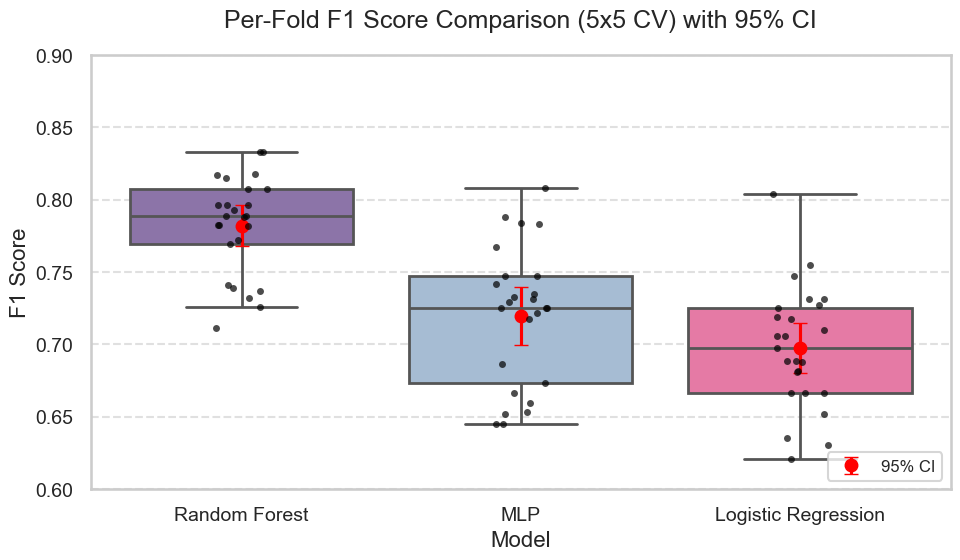

In [128]:
#whisker plot to show significance
df_f1 = pd.DataFrame({
    "F1 Score": f1_scores_dict["Random Forest"] + f1_scores_dict["MLP"] + f1_scores_dict["Logistic Regression"],
    "Model": ["Random Forest"] * 25 + ["MLP"] * 25 + ["Logistic Regression"] * 25
})

f1_rf = np.array(f1_scores_dict["Random Forest"])
f1_mlp = np.array(f1_scores_dict["MLP"])
f1_lr = np.array(f1_scores_dict["Logistic Regression"])

t_rf_mlp, p_rf_mlp = ttest_rel(f1_rf, f1_mlp)
t_rf_lr, p_rf_lr = ttest_rel(f1_rf, f1_lr)
t_mlp_lr, p_mlp_lr = ttest_rel(f1_mlp, f1_lr)

from scipy.stats import t

means = []
cis = []
t_val = t.ppf(0.975, df=24)

for model in models:
    scores = np.array(f1_scores_dict[model])
    mean = scores.mean()
    ci = t_val * scores.std(ddof=1) / np.sqrt(len(scores))
    means.append(mean)
    cis.append(ci)

custom_palette = {
    "Random Forest": "#8c6bb1",
    "MLP": "#9ebcda",
    "Logistic Regression": "#f768a1"
}

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_f1, x="Model", y="F1 Score", showfliers=False, palette=custom_palette, linewidth=2.0)
sns.stripplot(data=df_f1, x="Model", y="F1 Score", color='black', size=5, jitter=True, alpha=0.7)

for i, (mean, ci) in enumerate(zip(means, cis)):
    plt.errorbar(i, mean, yerr=ci, fmt='o', color='red', capsize=5, label='95% CI' if i == 0 else "")

plt.title("Per-Fold F1 Score Comparison (5x5 CV) with 95% CI", fontsize=18, pad=20)
plt.ylim(0.6, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xlabel("Model", fontsize=16)
plt.ylabel("F1 Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

print("\nPaired t-test p-values (F1 Score comparisons):")
print(f"RF vs MLP: {p_rf_mlp:.2e}")
print(f"RF vs LR:  {p_rf_lr:.2e}")
print(f"MLP vs LR: {p_mlp_lr:.2e}")

plt.ylim(0.6, 0.9)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

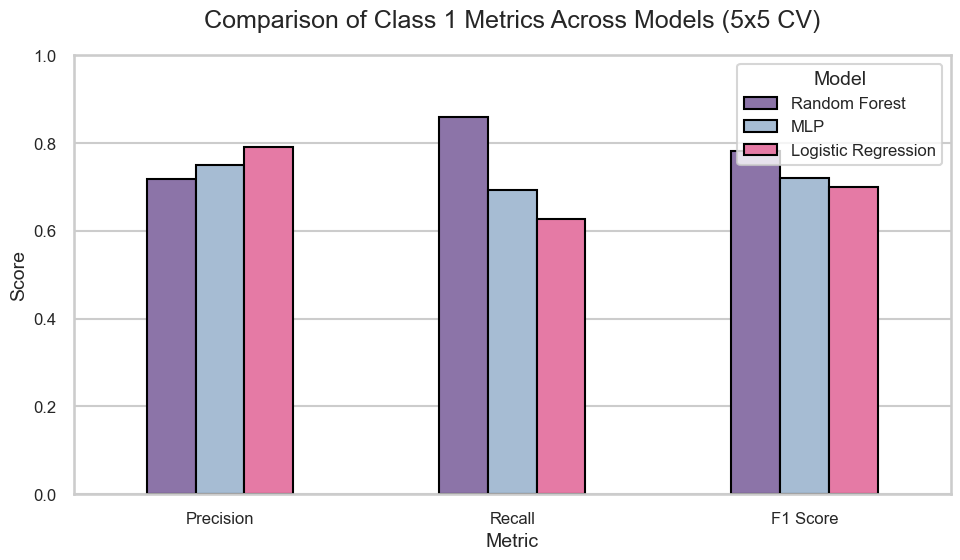

In [129]:
#barplot comparing models

model_metrics = {
    "Model": [],
    "Metric": [],
    "Score": []
}

for name in models:
    y_true = cv_preds[name]["true"]
    y_pred = cv_preds[name]["pred"]

    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    model_metrics["Model"].extend([name]*3)
    model_metrics["Metric"].extend(["Precision", "Recall", "F1 Score"])
    model_metrics["Score"].extend([precision, recall, f1])

metrics_df = pd.DataFrame(model_metrics)

# Plotting
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

custom_palette = {
    "Random Forest": "#8c6bb1",
    "MLP": "#9ebcda",
    "Logistic Regression": "#f768a1"
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=metrics_df, 
    x="Metric", 
    y="Score", 
    hue="Model", 
    palette=custom_palette,
    edgecolor='black',
    dodge=True,
    width=0.5
)

plt.title("Comparison of Class 1 Metrics Across Models (5x5 CV)", fontsize=18, pad=20)
plt.xlabel("Metric", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.ylim(0.0, 1.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

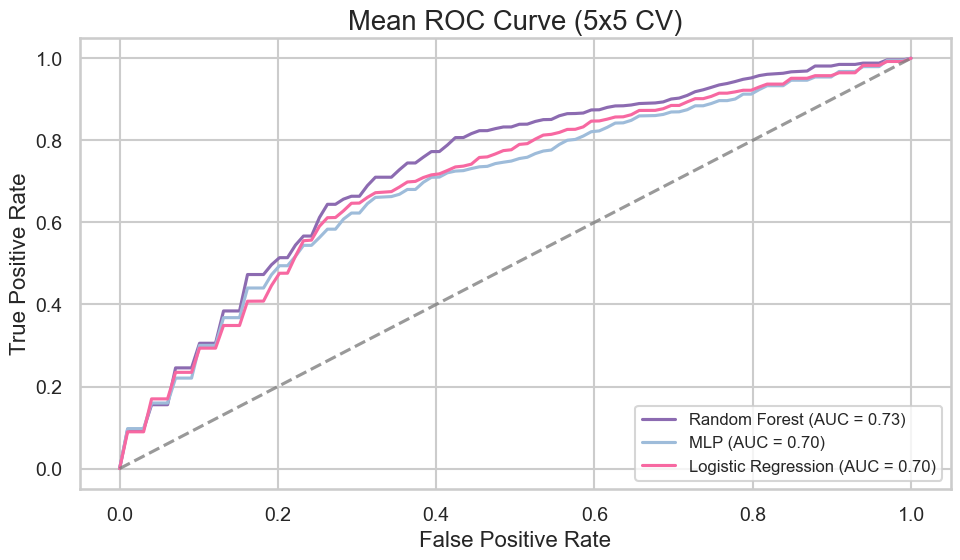

In [130]:
#ROC curve for each model
plt.figure(figsize=(10, 6))

custom_palette = {
    "Random Forest": "#8c6bb1",
    "MLP": "#9ebcda",
    "Logistic Regression": "#f768a1"
}

for name, model in models.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_idx, test_idx) in enumerate(rkf.split(X_filtered, y_filtered), 1):
        X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
        y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]

        pca = PCA(n_components=0.99, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        model.fit(X_train_pca, y_train)
        y_proba = model.predict_proba(X_test_pca)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC = {mean_auc:.2f})", color=custom_palette[name])

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', alpha=0.8)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Mean ROC Curve (5x5 CV)")
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [131]:
#hyperparameter optimisation
y = pd.Series(y)
y_binary = y.copy()
y_binary[y_binary.isin([1, 2])] = 1
y_binary[y_binary == 0] = 0

mask = y_binary.isin([0, 1])
X_filtered = X[mask].select_dtypes(include=[np.number])
y_filtered = y_binary[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    test_size=0.15,
    stratify=y_filtered,
    random_state=42
)

pipeline = Pipeline([
    ('pca', PCA(n_components=0.99, random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

param_grid = {
    'rf__n_estimators': [1000],
    'rf__max_depth': [None],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [1, 2, 5],
    'rf__max_features': ['sqrt', 'log2', 0.2],
    'rf__bootstrap': [True],
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average="macro"),
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

best_thresh = 0.5
best_f1 = 0
thresholds = np.linspace(0.1, 0.9, 100)

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

y_pred_final = (y_proba >= best_thresh).astype(int)

print("\n Best RF hyperparameters:")
print(grid_search.best_params_)
print(f"Best Threshold for F1: {best_thresh:.2f}")
print(f"Best F1 Score on test set: {best_f1:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_final, digits=3))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

print("Precision / Recall / F1 (Class 1):")
print("Precision:", precision_score(y_test, y_pred_final, pos_label=1))
print("Recall:   ", recall_score(y_test, y_pred_final, pos_label=1))
print("F1 Score: ", f1_score(y_test, y_pred_final, pos_label=1))


Fitting 5 folds for each of 18 candidates, totalling 90 fits

 Best RF hyperparameters:
{'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 0.2, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
Best Threshold for F1: 0.49
Best F1 Score on test set: 0.815

Classification Report:
              precision    recall  f1-score   support

         0.0      0.737     0.583     0.651        24
         1.0      0.767     0.868     0.815        38

    accuracy                          0.758        62
   macro avg      0.752     0.726     0.733        62
weighted avg      0.756     0.758     0.751        62

Confusion Matrix:
[[14 10]
 [ 5 33]]
Precision / Recall / F1 (Class 1):
Precision: 0.7674418604651163
Recall:    0.868421052631579
F1 Score:  0.8148148148148148


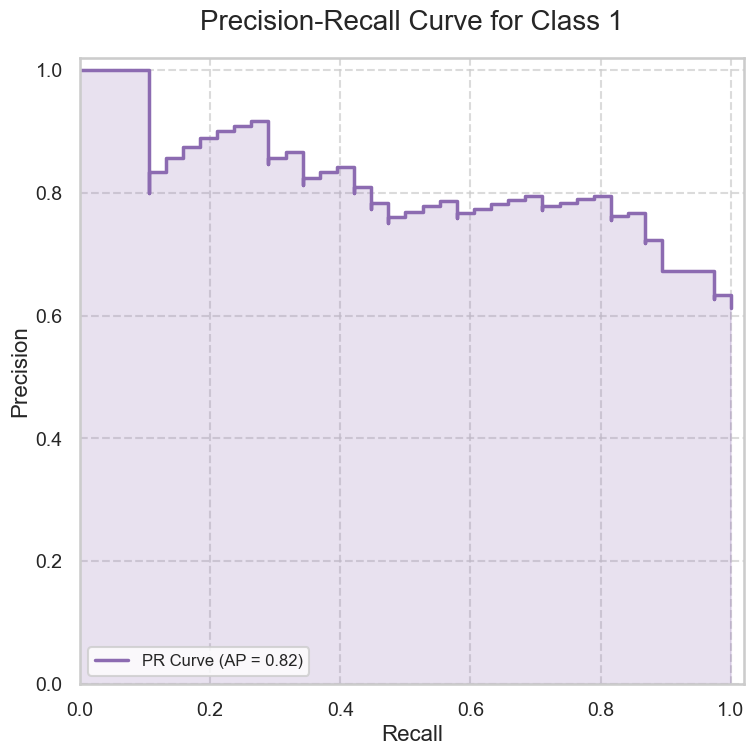

In [132]:
#precision-recall curve for class 0 vs 1/2
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

sns.set_context("talk", font_scale=1.2)
sns.set_style("whitegrid")

plt.figure(figsize=(8, 8))
plt.plot(
    recall, precision,
    drawstyle='steps-post',
    linewidth=2.5,
    color="#8c6bb1",
    label=f'PR Curve (AP = {avg_precision:.2f})'
)

plt.fill_between(recall, precision, step='post', alpha=0.2, color="#8c6bb1")

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-Recall Curve for Class 1', fontsize=20, pad=20)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', labelsize=14)
plt.legend(loc='lower left', fontsize=12)
plt.xlim([0, 1.02])
plt.ylim([0, 1.02])
plt.tight_layout()
plt.show()


Random Forest (0 vs 1/2)
Fixed Threshold: 0.52

Classification Report:
              precision    recall  f1-score   support

         0.0      0.514     0.750     0.610        24
         1.0      0.778     0.553     0.646        38

    accuracy                          0.629        62
   macro avg      0.646     0.651     0.628        62
weighted avg      0.676     0.629     0.632        62

Confusion Matrix:
[[18  6]
 [17 21]]
Precision / Recall / F1 (Class 1 - Mutated):
Precision: 0.7777777777777778
Recall:    0.5526315789473685
F1 Score:  0.6461538461538462


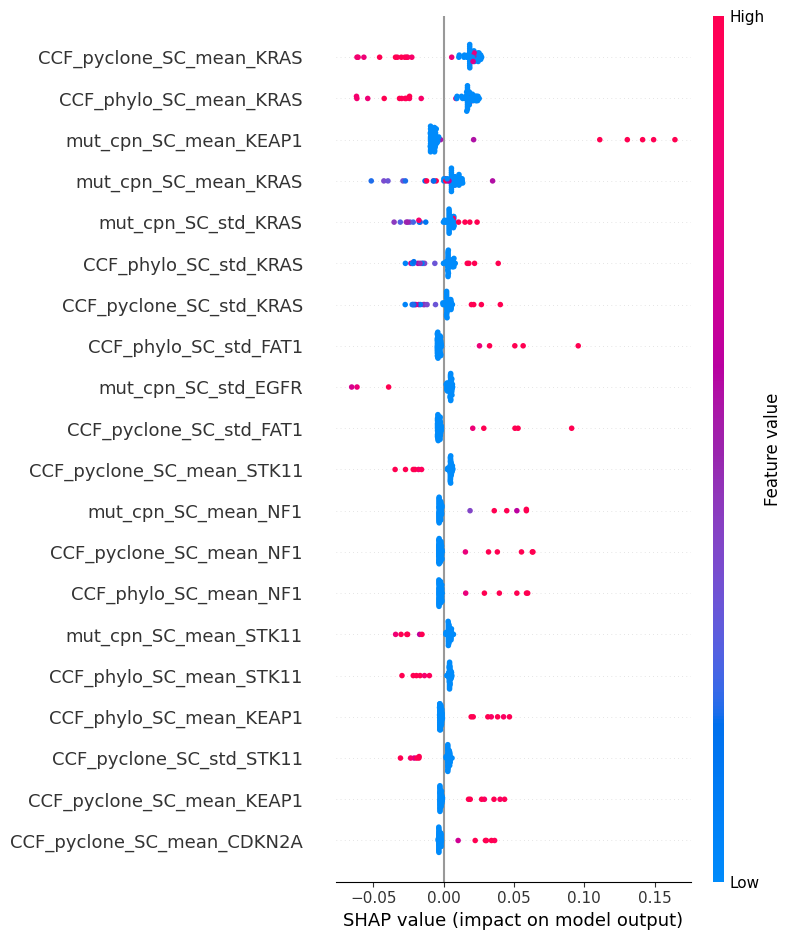

In [5]:
#shap analysis for class 0 vs 1/2
y = pd.Series(y)
y_binary = y.copy()
y_binary[y_binary.isin([1, 2])] = 1
y_binary[y_binary == 0] = 0

mask = y_binary.isin([0, 1])
X_filtered = X[mask].select_dtypes(include=[np.number])
y_filtered = y_binary[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    test_size=0.15,
    stratify=y_filtered,
    random_state=42
)


rf = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    max_depth=None,
    max_features=0.2,
    min_samples_split=2,
    min_samples_leaf=5,
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

def evaluate_model_fixed_threshold(name, y_true, y_proba, threshold=0.52):
    y_pred = (y_proba >= threshold).astype(int)
    
    print(f"\n{name}")
    print(f"Fixed Threshold: {threshold:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Precision / Recall / F1 (Class 1 - Mutated):")
    print("Precision:", precision_score(y_true, y_pred, pos_label=1))
    print("Recall:   ", recall_score(y_true, y_pred, pos_label=1))
    print("F1 Score: ", f1_score(y_true, y_pred, pos_label=1))

evaluate_model_fixed_threshold("Random Forest (0 vs 1/2)", y_test, y_proba_rf, threshold=0.52)



explainer = shap.TreeExplainer(rf, model_output="raw")
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_class1 = shap_values[1]
else:
    shap_class1 = shap_values[:, :, 1]

shap.summary_plot(
    shap_class1,
    features=X_test,  
    feature_names=X_test.columns  
)


C:\Users\musta\AppData\Local\Temp\ipykernel_12676\3326924947.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


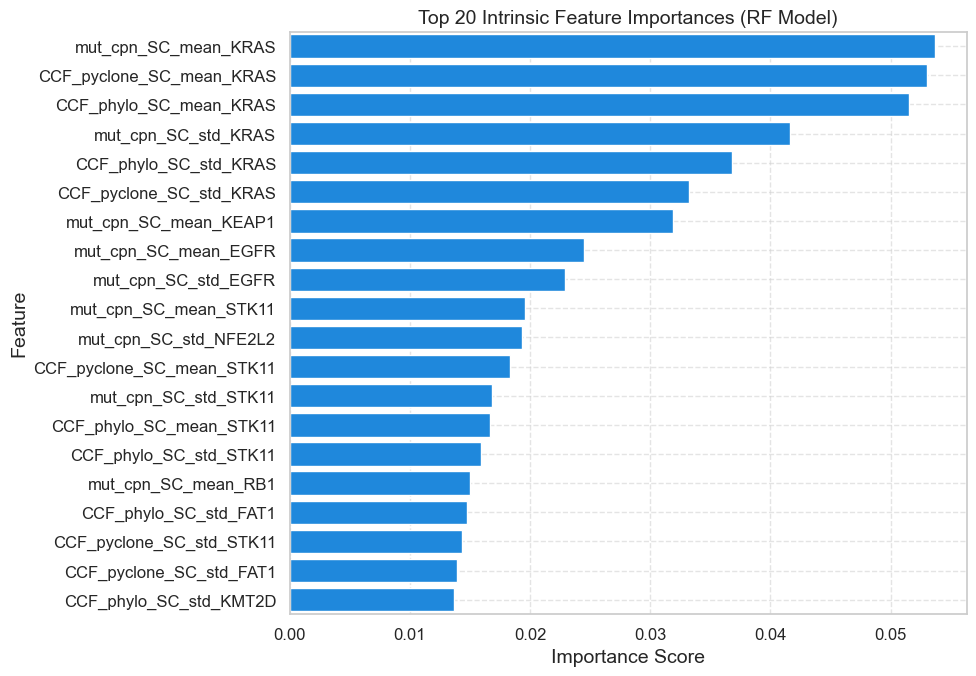

In [16]:
#intrinsic feature importance
if hasattr(rf, 'feature_importances_'):
    importances = rf.feature_importances_

    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train.columns[:len(importances)]
    else:
        feature_names = [f"Feature {i}" for i in range(len(importances))]

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    
    top_n = 20
    palette = sns.color_palette("Blues", n_colors=top_n)

    plt.figure(figsize=(10, 7))
    sns.barplot(
        data=importance_df.head(top_n),
        x="Importance",
        y="Feature",
        palette=["#008bfb"] * top_n,
    )
    sns.set_theme(style="whitegrid", palette="deep", font_scale=1.2)
    plt.title(f"Top {top_n} Intrinsic Feature Importances (RF Model)", fontsize=14)
    plt.xlabel("Importance Score", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', color='lightgray', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("RF model does not have feature importances")


Data Split Summary:
Training Set Size: 350 samples
Test Set Size:     62 samples
Total Features:    2430 columns
Class Distribution (Train):
ClonalStatus_TP53
0.0    134
1.0    216
Name: count, dtype: int64
Class Distribution (Test):
ClonalStatus_TP53
0.0    24
1.0    38
Name: count, dtype: int64

Best N (SHAP features): 17
Best Avg F1 (Recall ≥ 0.90): 0.697 at Threshold = 0.50

Classification Report:
              precision    recall  f1-score   support

         0.0      0.684     0.542     0.605        24
         1.0      0.744     0.842     0.790        38

    accuracy                          0.726        62
   macro avg      0.714     0.692     0.697        62
weighted avg      0.721     0.726     0.718        62

Confusion Matrix:
[[13 11]
 [ 6 32]]

Precision / Recall / F1 (Class 1 - Mutated):
Precision: 0.7441860465116279
Recall:    0.8421052631578947
F1 Score:  0.7901234567901234


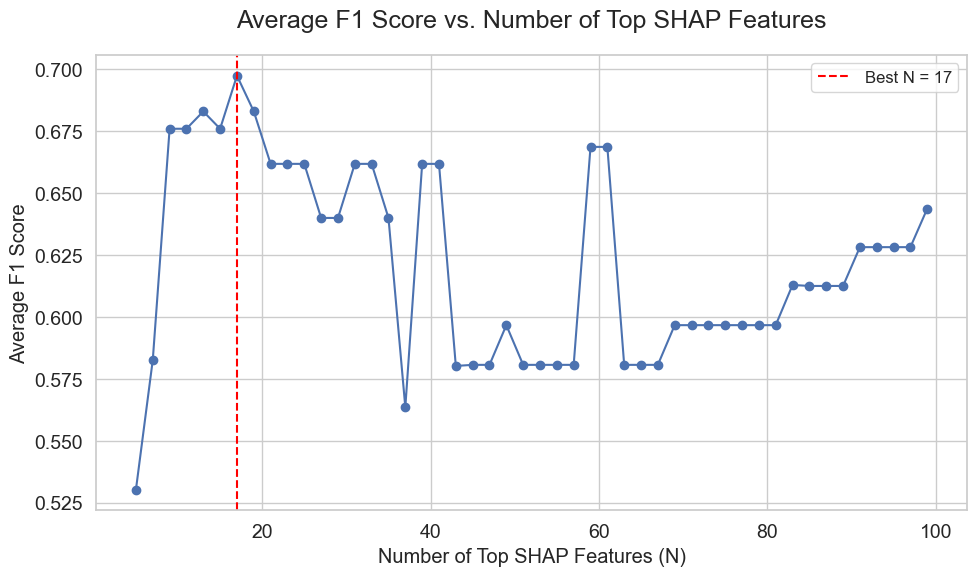

In [37]:
shap_importance = pd.DataFrame(shap_class1, columns=X_test.columns).abs().mean().sort_values(ascending=False)
max_n = min(100, len(shap_importance))

def print_data_split_info(X_train, X_test, y_train, y_test):
    print(f"\nData Split Summary:")
    print(f"Training Set Size: {X_train.shape[0]} samples")
    print(f"Test Set Size:     {X_test.shape[0]} samples")
    print(f"Total Features:    {X_train.shape[1]} columns")
    print(f"Class Distribution (Train):\n{y_train.value_counts().sort_index()}")
    print(f"Class Distribution (Test):\n{y_test.value_counts().sort_index()}")

print_data_split_info(X_train, X_test, y_train, y_test)

def optimise_threshold_macro_f1_min(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 100)
    best_macro_f1 = 0
    best_thresh = 0.5
    best_pred = None

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        f1_0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
        f1_1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall_1 = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        macro_f1 = (f1_0 + f1_1) / 2

        if f1_0 >= 0.5 and f1_1 >= 0.5 and recall_1 >= 0.90:
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                best_thresh = t
                best_pred = y_pred

    if best_pred is None:
        fallback_pred = (y_proba >= 0.5).astype(int)
        best_macro_f1 = f1_score(y_true, fallback_pred, average='macro', zero_division=0)
        best_thresh = 0.5
        best_pred = fallback_pred

    return best_macro_f1, best_thresh, best_pred

results = []
for n in range(5, max_n + 1, 5):
    top_features = shap_importance.head(n).index.tolist()
    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]

    rf = RandomForestClassifier(
        n_estimators=1000,
        class_weight='balanced',
        max_depth=None,
        min_samples_leaf=5,
        max_features=0.2,
        random_state=42,
        bootstrap=True,
        n_jobs=-1,
        min_samples_split=2
    )

    rf.fit(X_train_top, y_train)
    y_proba = rf.predict_proba(X_test_top)[:, 1]

    f1, thresh, y_pred = optimise_threshold_macro_f1_min(y_test, y_proba)
    results.append((n, f1, thresh, y_pred, y_proba, rf, top_features))

best_n, best_f1, best_thresh, best_y_pred, best_y_proba, best_model, best_features = max(
    results, key=lambda x: x[1]
)

print(f"\nBest N (SHAP features): {best_n}")
print(f"Best Avg F1 (Recall ≥ 0.90): {best_f1:.3f} at Threshold = {best_thresh:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, best_y_pred, digits=3))

print("Confusion Matrix:")
print(confusion_matrix(y_test, best_y_pred))

print("\nPrecision / Recall / F1 (Class 1 - Mutated):")
print("Precision:", precision_score(y_test, best_y_pred, pos_label=1))
print("Recall:   ", recall_score(y_test, best_y_pred, pos_label=1))
print("F1 Score: ", f1_score(y_test, best_y_pred, pos_label=1))

f1_scores = [r[1] for r in results]
n_vals = [r[0] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(n_vals, f1_scores, marker='o')
plt.axvline(best_n, color='red', linestyle='--', label=f'Best N = {best_n}')
plt.title("Average F1 Score vs. Number of Top SHAP Features", fontsize=18, pad=20)
plt.xlabel("Number of Top SHAP Features (N)")
plt.ylabel("Average F1 Score")
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------------------------------#

Optimal Threshold (Max F1 for Class 2): 0.500
Best F1 Score (Class 2): 0.273

Classification Report:
              precision    recall  f1-score   support

     Class 1      0.921     0.841     0.879        69
     Class 2      0.214     0.375     0.273         8

    accuracy                          0.792        77
   macro avg      0.567     0.608     0.576        77
weighted avg      0.847     0.792     0.816        77

Confusion Matrix:
[[58 11]
 [ 5  3]]


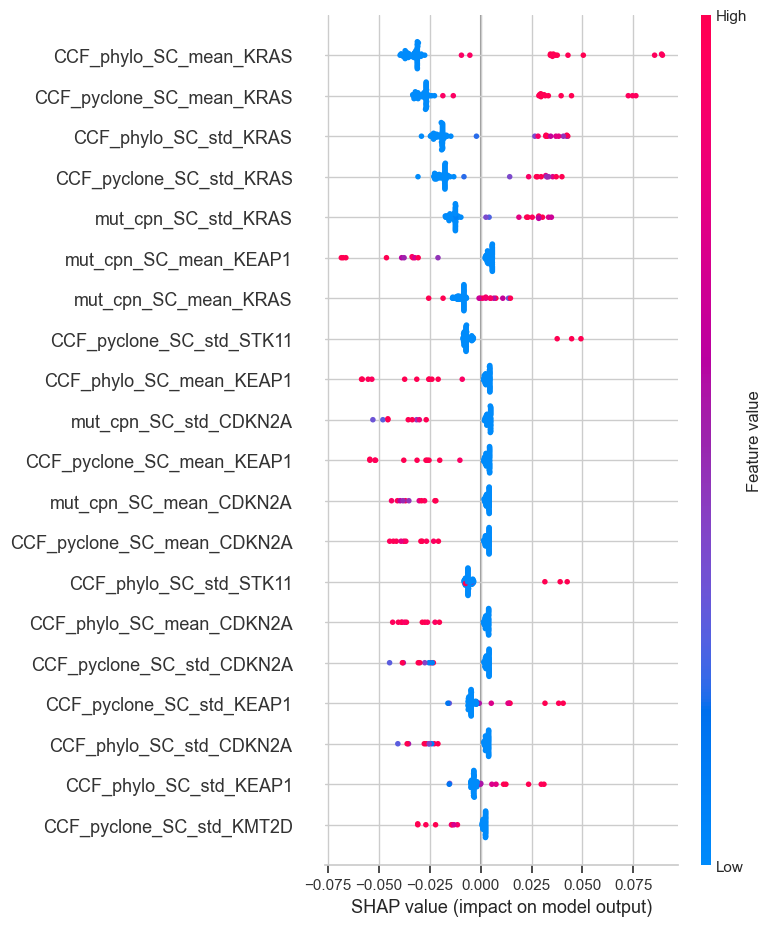

In [17]:
#class 1 vs 2 classifier
mask = y.isin([1, 2])
X_filtered = X[mask].select_dtypes(include=[np.number])
y_filtered = y[mask]
y_binary = (y_filtered == 2).astype(int)


X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_filtered, y_binary,
    test_size=0.3,
    stratify=y_binary,
    random_state=42
)

rf = RandomForestClassifier(
    random_state=42,
    n_estimators=1000,
    class_weight='balanced',
    max_depth=None,
    max_features=0.2,
    min_samples_split=2,
    min_samples_leaf=5,
    bootstrap=True,
    n_jobs=-1
)
rf.fit(X_train_raw, y_train)

y_proba = rf.predict_proba(X_test_raw)[:, 1]
best_f1 = 0
best_threshold = 0.5

for thresh in np.linspace(0.01, 0.99, 99):
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, average='binary', zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

y_pred_final = (y_proba >= best_threshold).astype(int)

print(f"Optimal Threshold (Max F1 for Class 2): {best_threshold:.3f}")
print(f"Best F1 Score (Class 2): {best_f1:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=["Class 1", "Class 2"], digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))


explainer = shap.TreeExplainer(rf, model_output="raw")
shap_values = explainer.shap_values(X_test_raw)

shap_class2 = shap_values[1] if isinstance(shap_values, list) else shap_values[:, :, 1]

shap.summary_plot(
    shap_class2,
    features=X_test_raw,
    feature_names=X_test_raw.columns
)


C:\Users\musta\AppData\Local\Temp\ipykernel_12676\3737767224.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


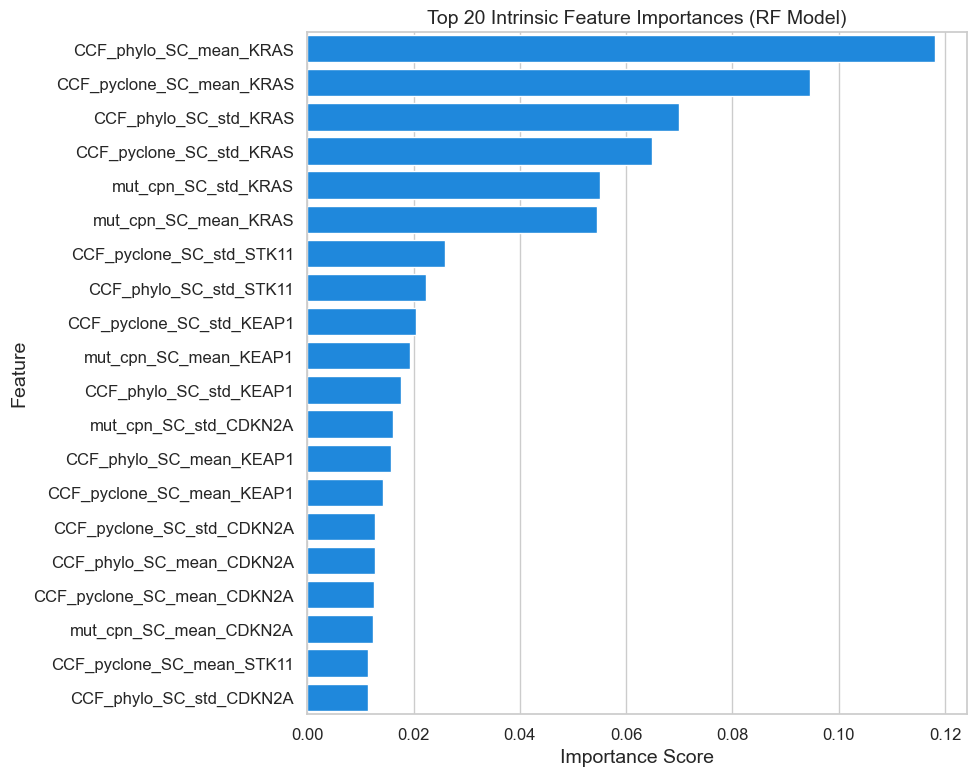

In [18]:
#intrinsic tree feature importances class 1 vs 2
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train_raw.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance_df.head(20),
    y='Feature',
    x='Importance',
    palette=["#008bfb"]
)
plt.title('Top 20 Intrinsic Feature Importances (RF Model)', fontsize=14)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
#shap analysis for class 1 vs 2 classifier
shap_df = pd.DataFrame(shap_class2, columns=X_train_raw.columns)

shap_importance = shap_df.abs().mean().sort_values(ascending=False)
max_n = min(100, len(shap_importance))



def optimise_threshold_f1_class2(y_true, y_proba):
    best_f1 = 0
    best_thresh = 0.5
    best_pred = None
    best_precision = 0
    best_recall = 0

    for thresh in np.linspace(0.01, 0.99, 99):
        y_pred_thresh = (y_proba >= thresh).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred_thresh,
            average='binary', pos_label=1, zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            best_pred = y_pred_thresh
            best_precision = precision
            best_recall = recall

    return best_f1, best_thresh, best_pred, best_precision, best_recall

results = []
for n in range(5, max_n + 1, 2):
    top_features = shap_importance.head(n).index.tolist()
    X_train_top = X_train_raw[top_features]
    X_test_top = X_test_raw[top_features]

    rf_n = RandomForestClassifier(
        n_estimators=1000, class_weight='balanced',
        max_depth=None, min_samples_leaf=5, max_features=0.2,
        random_state=42, bootstrap=True, n_jobs=-1, min_samples_split=2
    )

    rf_n.fit(X_train_top, y_train)
    y_proba = rf_n.predict_proba(X_test_top)[:, 1]

    f1, thresh, y_pred, precision, recall = optimise_threshold_f1_class2(y_test, y_proba)
    results.append((n, f1, thresh, y_pred, y_proba, rf_n, top_features, precision, recall))


best_n, best_f1, best_thresh, best_y_pred, best_y_proba, best_model, best_features, best_precision, best_recall = max(results, key=lambda x: x[1])

print(f"\nBest number of SHAP-selected features: {best_n}")
print(f"Best F1 Score (Class 2): {best_f1:.3f} at Threshold = {best_thresh:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, best_y_pred, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_test, best_y_pred))
print("Precision / Recall / F1 (Class 2 = Label 1):")
print("Precision:", best_precision)
print("Recall:   ", best_recall)
print("F1 Score: ", best_f1)


f1_scores = [r[1] for r in results]
n_vals = [r[0] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(n_vals, f1_scores, marker='o')
plt.axvline(best_n, color='red', linestyle='--', label=f'Best N = {best_n}')
plt.title("F1 Score for Class 2 vs. Number of Top SHAP Features", fontsize=18, pad=20)
plt.xlabel("Number of Top SHAP Features (N)")
plt.ylabel("F1 Score (Class 2)")
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()